In [5]:
from google.colab import files
uploaded = files.upload()


Saving OpthalmoAi.py to OpthalmoAi (1).py


In [6]:
import sys
sys.path.append('/content')
from OpthalmoAi import *
print("✅ Model architecture imported successfully!")


✅ Model architecture imported successfully!


In [7]:
# PyTorch + utils
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

# File handling & visualization
import os
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np


In [4]:
!gdown --id 1-oU6QSyyYNskulQcDIkwFMWrj8kskGOC -O best_model.pth
print("✅ Model downloaded from Drive")


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-oU6QSyyYNskulQcDIkwFMWrj8kskGOC
From (redirected): https://drive.google.com/uc?id=1-oU6QSyyYNskulQcDIkwFMWrj8kskGOC&confirm=t&uuid=642a16f6-a8e1-4ccd-aa04-cc515b3ecde5
To: /content/best_model.pth
100% 94.4M/94.4M [00:01<00:00, 55.9MB/s]
✅ Model downloaded from Drive


In [8]:
!ls -R /content


/content:
 best_model.pth       OpthalmoAi.py   sample_data
'OpthalmoAi (1).py'   __pycache__

/content/__pycache__:
OpthalmoAi.cpython-312.pyc

/content/sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [9]:
!gdown --id 1-oU6QSyyYNskulQcDIkwFMWrj8kskGOC -O best_model.pth


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-oU6QSyyYNskulQcDIkwFMWrj8kskGOC
From (redirected): https://drive.google.com/uc?id=1-oU6QSyyYNskulQcDIkwFMWrj8kskGOC&confirm=t&uuid=024ac016-634d-47ea-8c77-be1e9b85d37c
To: /content/best_model.pth
100% 94.4M/94.4M [00:05<00:00, 16.8MB/s]


In [10]:
# PyTorch + utils
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

# File handling & visualization
import os
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np


In [11]:
!gdown --id 1-oU6QSyyYNskulQcDIkwFMWrj8kskGOC -O best_model.pth
print("✅ Model downloaded from Drive")


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-oU6QSyyYNskulQcDIkwFMWrj8kskGOC
From (redirected): https://drive.google.com/uc?id=1-oU6QSyyYNskulQcDIkwFMWrj8kskGOC&confirm=t&uuid=859ec944-d425-4d35-be92-530ca3011855
To: /content/best_model.pth
100% 94.4M/94.4M [00:00<00:00, 143MB/s]
✅ Model downloaded from Drive


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")


🚀 Using device: cuda


In [13]:
# ResNet50 with modified output
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5)  # 5 DR grades: 0-4
model = model.to(device)

# Load the downloaded weights
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()
print("✅ Model loaded successfully!")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 118MB/s]


✅ Model loaded successfully!


In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [15]:
uploaded_imgs = files.upload()  # Upload one or multiple retinal images
test_images = list(uploaded_imgs.keys())
print(f"✅ Uploaded images: {test_images}")


Saving ratinal test 2 abnromal.jpg to ratinal test 2 abnromal.jpg
✅ Uploaded images: ['ratinal test 2 abnromal.jpg']


In [16]:
class TestDataset(Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, img_path

test_dataset = TestDataset(test_images, transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


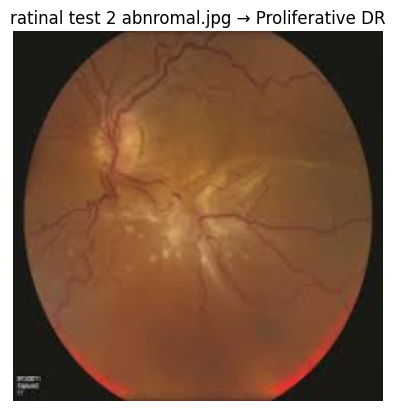

In [17]:
classes = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

for imgs, paths in test_loader:
    imgs = imgs.to(device)
    with torch.no_grad():
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        pred_class = classes[preds.item()]

    # Show image with predicted label
    img_np = imgs[0].cpu().permute(1, 2, 0).numpy()
    img_np = np.clip(img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
    plt.imshow(img_np)
    plt.title(f"{os.path.basename(paths[0])} → {pred_class}")
    plt.axis('off')
    plt.show()


In [20]:
!grep "def build_model" OpthalmoAi.py
